In [41]:
# Req Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind, chi2_contingency, pearsonr, spearmanr

## Manipulate Data

# Read csv into data frame
df = pd.read_csv('nyc_housing_base.csv')

# Fill missing values
df = df.fillna(0)
# drop rows with missing vals
df = df.dropna()

# PCA/Z-Score/etc


In [42]:
## Clean Data

# Remove dupped rows
df = df.drop_duplicates()


In [ ]:
##  Numerical Computing

# Convert data frame to numpy array
np_array = df.to_numpy()

# Convert headers to python list
headers_list = df.columns.tolist()

# Define num of cols in csv file
num_cols = 19

# Dict that maps header name to numbered column
header_to_num = {header: number for header, number in zip(headers_list, range(num_cols))}

# Col data for building area and sales price
building_area_data = np_array[:, header_to_num["bldgarea"]]
sales_price_data = np_array[:, header_to_num["sale_price"]]
# To do: implement second feature
yr_built_data = np_array[:, header_to_num["yearbuilt"]]

# Stats computations for building area (sq ft) (Independent)
mean_sales_price = np.mean(building_area_data)
med_sales_price = np.median(building_area_data)
std_sales_price = np.std(building_area_data)

# Stats computations for sales price (USD) (Dependent)
mean_sales_price = np.mean(sales_price_data)
med_sales_price = np.median(sales_price_data)
std_sales_price = np.std(sales_price_data)


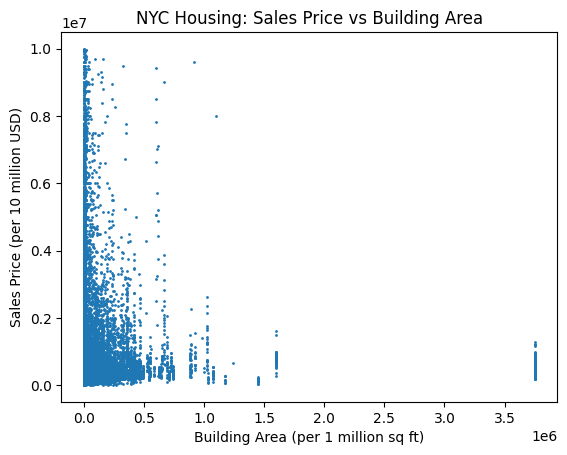

In [ ]:
## Data Visualization (Matplotlib)

# To Do: Work on Multi Dimensional Data Analysis

# Title
plt.title("NYC Housing: Sales Price vs Building Area")

# X axis
plt.xlabel("Building Area (per 1 million sq ft)")
#plt.ticklabel_format(style='plain', axis='x') 

# Y axis
plt.ylabel("Sales Price (per 10 million USD)")
#plt.ticklabel_format(style='plain', axis='y') 

# Make scatter plot of sales building area vs sales price
plt.scatter(building_area_data, sales_price_data, s=1, )

# Scale the plot
#plt.xlim(0, 1)

# start, end = 0, 3.5
# plt.xticks(np.arange(start, end + 0.25, 0.25))

# Show graph
plt.show()

In [ ]:
# ML (sckit-learn)

# Feature(s)

# If using one feature, need to reshape array into single column 2D array
# X = building_area_data.reshape(-1, 1)

# IF using Z # of features, stack arrays as columns to form single, 2D array with Z columns
# 2 features used here, so stack arrays as cols to form single, 2D array with 2 cols
X = np.column_stack((building_area_data, yr_built_data))

# Target
y = sales_price_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 10)

# Fit and predict with linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Train model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Cross validation (5-fold)
# Returns numpy array of floating point scores
# Each element of returned array is perf metric of model for one specific test fold
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

# OLS linear regression doesn't have hyperparams to tune

# Print individual scores for each score
print(f"Cross-validation scores: {cv_scores}")
# Print mean score and std across all folds
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Scores: {np.std(cv_scores):.2f}")


Cross-validation scores: [0.0186475  0.01383288 0.02311559 0.01875778 0.01851089]
Mean CV Score: 0.02
Standard Deviation of CV Scores: 0.00
